# Pool Architecture Experiment Results

In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms

from db import conn

In [2]:
%matplotlib inline

In [3]:
sns.set_style("whitegrid")

In [4]:
cursor = conn.cursor()
experiment_rows = [r for r in cursor.execute("""
    select g.name, args, dev_metric, test_metric from experiments e
    join experiment_groups g on e.group_id=g.gid
    where g.name=?""", ('mpcnn-v2-pool-fix-params-and-seed',))]

In [5]:
len(experiment_rows)

120

In [6]:
experiment_results = {
    'trecqa': [],
    'wikiqa': [],
    'sick': []
}

for row in experiment_rows:
    args = json.loads(row[1])
    dev_metrics = json.loads(row[2])
    test_metrics = json.loads(row[3])
    dataset = args['dataset']
    
    if args['arch'] == 'mpcnn_pool_max_only':
        arch = 'Max'
    elif args['arch'] == 'mpcnn_pool_no_mean_sym':
        arch = 'Max, Min'
    elif args['arch'] == 'mpcnn_pool_mean_sym':
        arch = 'All'
    else:
        arch = 'MP-CNN'
    
    res_base = {
        'arch': arch,
        'dataset': dataset,
        'seed': args['seed']
    }
    
    results = []
    
    if dataset in ('trecqa', 'wikiqa'):
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MAP', 'metric_val': dev_metrics['map']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MRR', 'metric_val': dev_metrics['mrr']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MAP', 'metric_val': test_metrics['map']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MRR', 'metric_val': test_metrics['mrr']}})
    elif dataset == 'sick':
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'pearson', 'metric_val': dev_metrics['pearson']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'spearman', 'metric_val': dev_metrics['spearman']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'pearson', 'metric_val': test_metrics['pearson']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'spearman', 'metric_val': test_metrics['spearman']}})
    
    experiment_results[dataset].extend(results)

In [7]:
trecqa = pd.DataFrame(experiment_results['trecqa'])
wikiqa = pd.DataFrame(experiment_results['wikiqa'])
sick = pd.DataFrame(experiment_results['sick'])

In [8]:
trecqa.head(8)

,arch,dataset,metric_name,metric_val,seed,split
0,MP-CNN,trecqa,MAP,0.7972,269504,dev
1,MP-CNN,trecqa,MRR,0.8658,269504,dev
2,MP-CNN,trecqa,MAP,0.7555,269504,test
3,MP-CNN,trecqa,MRR,0.8161,269504,test
4,Max,trecqa,MAP,0.8086,269504,dev
5,Max,trecqa,MRR,0.8966,269504,dev
6,Max,trecqa,MAP,0.7835,269504,test
7,Max,trecqa,MRR,0.8443,269504,test


In [9]:
archs = ['Max', 'Max, Min', 'All']
def compare_change_to_baseline(df, metric):
    changes = {'MP-CNN': 'baseline'}
    config_ids = df['seed'].unique()
    for arch in archs:
        diffs = []
        for config_id in config_ids:
            baseline = df[(df['seed'] == config_id) & (df['arch'] == 'MP-CNN')].iloc[0]['metric_val']
            conf_perf = df[(df['seed'] == config_id) & (df['arch'] == arch)].iloc[0]['metric_val']
            diffs.append(conf_perf - baseline)

        print(f'Architecture: {arch} pooling')
        print(f'Median of {metric} change compared with max pooling baseline: {np.median(diffs):.4f}')
        print(f'Mean of {metric} change compared with max pooling baseline: {np.mean(diffs):.4f}')
        diff = np.median(diffs)
        changes[arch] = f'+{diff:.4f}' if diff > 0 else f'{diff:.4f}'
    
    return changes

## TrecQA

In [10]:
trec_map_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'test')]
trec_mrr_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'test')]
trec_map_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'dev')]
trec_mrr_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'dev')]

In [11]:
trec_map_intervals = {}
for arch in trec_map_vs_archs_test['arch'].unique():
    arr = trec_map_vs_archs_test[trec_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    trec_map_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.7324, 0.7985)
Max: (0.7702, 0.7841)
All: (0.7622, 0.7885)
Max, Min: (0.7100, 0.8057)


In [12]:
trec_mrr_intervals = {}
for arch in trec_mrr_vs_archs_test['arch'].unique():
    arr = trec_mrr_vs_archs_test[trec_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    trec_mrr_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.7794, 0.8433)
Max: (0.8380, 0.8544)
All: (0.8136, 0.8339)
Max, Min: (0.7815, 0.8628)


In [13]:
trec_map_delta = compare_change_to_baseline(trec_map_vs_archs_test, 'MAP')

Architecture: Max pooling
Median of MAP change compared with max pooling baseline: 0.0062
Mean of MAP change compared with max pooling baseline: 0.0117
Architecture: Max, Min pooling
Median of MAP change compared with max pooling baseline: 0.0165
Mean of MAP change compared with max pooling baseline: -0.0076
Architecture: All pooling
Median of MAP change compared with max pooling baseline: 0.0028
Mean of MAP change compared with max pooling baseline: 0.0099


In [14]:
trec_mrr_delta = compare_change_to_baseline(trec_mrr_vs_archs_test, 'MRR')

Architecture: Max pooling
Median of MRR change compared with max pooling baseline: 0.0232
Mean of MRR change compared with max pooling baseline: 0.0348
Architecture: Max, Min pooling
Median of MRR change compared with max pooling baseline: 0.0248
Mean of MRR change compared with max pooling baseline: 0.0108
Architecture: All pooling
Median of MRR change compared with max pooling baseline: 0.0000
Mean of MRR change compared with max pooling baseline: 0.0124


## WikiQA

In [15]:
wikiqa_map_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'test')]
wikiqa_mrr_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'test')]
wikiqa_map_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'dev')]
wikiqa_mrr_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'dev')]

In [16]:
wikiqa_map_intervals = {}
for arch in wikiqa_map_vs_archs_test['arch'].unique():
    arr = wikiqa_map_vs_archs_test[wikiqa_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    wikiqa_map_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.6440, 0.7223)
Max: (0.6855, 0.6947)
All: (0.6199, 0.7173)
Max, Min: (0.6445, 0.7043)


In [17]:
wikiqa_mrr_intervals = {}
for arch in wikiqa_mrr_vs_archs_test['arch'].unique():
    arr = wikiqa_mrr_vs_archs_test[wikiqa_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    wikiqa_mrr_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.6546, 0.7359)
Max: (0.6992, 0.7096)
All: (0.6264, 0.7306)
Max, Min: (0.6513, 0.7194)


In [18]:
wikiqa_map_delta = compare_change_to_baseline(wikiqa_map_vs_archs_test, 'MAP')

Architecture: Max pooling
Median of MAP change compared with max pooling baseline: -0.0167
Mean of MAP change compared with max pooling baseline: 0.0069
Architecture: Max, Min pooling
Median of MAP change compared with max pooling baseline: -0.0181
Mean of MAP change compared with max pooling baseline: -0.0087
Architecture: All pooling
Median of MAP change compared with max pooling baseline: -0.0101
Mean of MAP change compared with max pooling baseline: -0.0145


In [19]:
wikiqa_mrr_delta = compare_change_to_baseline(wikiqa_mrr_vs_archs_test, 'MRR')

Architecture: Max pooling
Median of MRR change compared with max pooling baseline: -0.0167
Mean of MRR change compared with max pooling baseline: 0.0092
Architecture: Max, Min pooling
Median of MRR change compared with max pooling baseline: -0.0148
Mean of MRR change compared with max pooling baseline: -0.0099
Architecture: All pooling
Median of MRR change compared with max pooling baseline: -0.0086
Mean of MRR change compared with max pooling baseline: -0.0167


## SICK

In [20]:
sick_pearson_vs_archs_test = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'test')]
sick_spearman_vs_archs_test = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'test')]
sick_pearson_vs_archs_dev = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'dev')]
sick_spearman_vs_archs_dev = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'dev')]

In [21]:
sick_pearson_intervals = {}
for arch in sick_pearson_vs_archs_test['arch'].unique():
    arr = sick_pearson_vs_archs_test[sick_pearson_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    sick_pearson_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.8049, 0.8899)
Max: (0.8640, 0.8720)
All: (0.8465, 0.8726)
Max, Min: (0.8646, 0.8704)


In [22]:
sick_spearman_intervals = {}
for arch in sick_spearman_vs_archs_test['arch'].unique():
    arr = sick_spearman_vs_archs_test[sick_spearman_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    sick_spearman_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.7599, 0.8251)
Max: (0.7995, 0.8100)
All: (0.8034, 0.8116)
Max, Min: (0.8003, 0.8120)


In [23]:
sick_pearson_delta = compare_change_to_baseline(sick_pearson_vs_archs_test, 'pearson')

Architecture: Max pooling
Median of pearson change compared with max pooling baseline: -0.0010
Mean of pearson change compared with max pooling baseline: 0.0206
Architecture: Max, Min pooling
Median of pearson change compared with max pooling baseline: 0.0019
Mean of pearson change compared with max pooling baseline: 0.0201
Architecture: All pooling
Median of pearson change compared with max pooling baseline: 0.0004
Mean of pearson change compared with max pooling baseline: 0.0122


In [24]:
sick_spearman_delta = compare_change_to_baseline(sick_spearman_vs_archs_test, 'spearman')

Architecture: Max pooling
Median of spearman change compared with max pooling baseline: -0.0027
Mean of spearman change compared with max pooling baseline: 0.0123
Architecture: Max, Min pooling
Median of spearman change compared with max pooling baseline: -0.0006
Mean of spearman change compared with max pooling baseline: 0.0137
Architecture: All pooling
Median of spearman change compared with max pooling baseline: 0.0012
Mean of spearman change compared with max pooling baseline: 0.0150


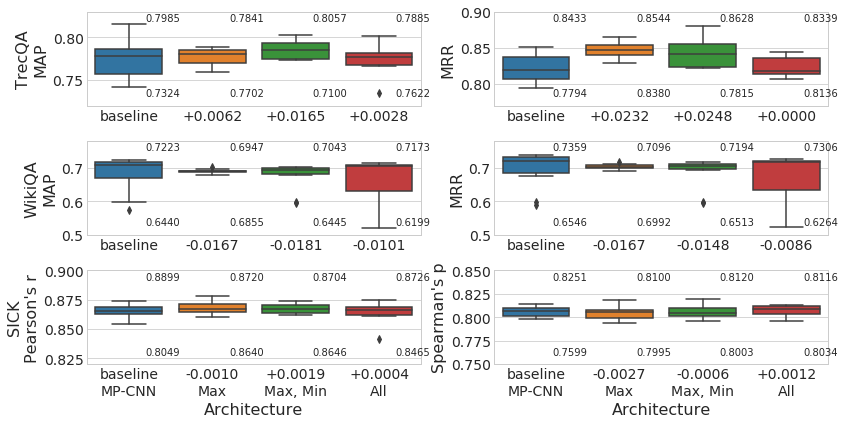

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 6)
title_size = 18
axis_size = 16
tick_size = 14

archs = ['MP-CNN', 'Max', 'Max, Min', 'All']
ax = plt.subplot(321)
sns.boxplot(x='arch', y='metric_val', data=trec_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('TrecQA\nMAP', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.72, 0.83))
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([trec_map_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), trec_map_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), trec_map_intervals[a][1])

ax = plt.subplot(322)
sns.boxplot(x='arch', y='metric_val', data=trec_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.77, 0.9))
ax.xaxis.set_ticklabels([trec_mrr_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), trec_mrr_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), trec_mrr_intervals[a][1])

ax = plt.subplot(323)
sns.boxplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('WikiQA\nMAP', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.5, 0.78))
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([wikiqa_map_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), wikiqa_map_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), wikiqa_map_intervals[a][1])

ax = plt.subplot(324)
sns.boxplot(x='arch', y='metric_val', data=wikiqa_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.5, 0.78))
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([wikiqa_mrr_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), wikiqa_mrr_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), wikiqa_mrr_intervals[a][1])

ax = plt.subplot(325)
sns.boxplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.ylabel("SICK\nPearson's r", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.82, 0.9))
ax.xaxis.set_ticklabels([sick_pearson_delta[a] + '\n' + a for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), sick_pearson_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), sick_pearson_intervals[a][1])

ax = plt.subplot(326)
sns.boxplot(x='arch', y='metric_val', data=sick_spearman_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Spearman's p", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.75, 0.85))
ax.xaxis.set_ticklabels([sick_spearman_delta[a] + '\n' + a for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), sick_spearman_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), sick_spearman_intervals[a][1])
plt.tight_layout()
# plt.subplots_adjust(top=0.8, hspace=0.2)
plt.savefig('pool_arch_violin.pdf')